# Playground for Biophysical Models

In [125]:
%load_ext autoreload
%autoreload 2

import pinot
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [78]:
ds = pinot.data.moonshot_multi()

# send data to cuda
ds = ds.to('cuda')

This dataset has 6 values, three for each assay.

They are as follows:

```
    KEY
        r is rapidfire
        f is fluorescence

    DESCRIPTIONS
    
        'r_inhibition_at_20_uM',
        'r_inhibition_at_50_uM',
        'r_avg_IC50',
        
        'f_inhibition_at_20_uM',
        'f_inhibition_at_50_uM',
        'f_avg_IC50'
```

In [79]:
g, y = ds.ds[9]
y[3] # `f_inhibition_at_20_uM`

tensor(0.0361, device='cuda:0')

## Set up net and optimizer

In [80]:
def get_net_and_optimizer(architecture, regressor_type='vgp',
                          n_inducing_points=50, optimizer='Adam',
                          lr=1e-4, weight_decay=0.01, device='cuda'):
    """
    """
    representation = pinot.representation.sequential.SequentialMix(
        architecture,
    )

    if regressor_type == "gp":
        output_regressor = pinot.regressors.ExactGaussianProcessRegressor
    elif regressor_type == "nn":
        output_regressor = pinot.regressors.NeuralNetworkRegressor 
    else:
        output_regressor = pinot.regressors.VariationalGaussianProcessRegressor

    # First train a fully supervised Net to use as Baseline
    net = pinot.Net(
        representation=representation,
        output_regressor_class=output_regressor,
        n_inducing_points=n_inducing_points
    )
    optimizer = pinot.app.utils.optimizer_translation(
        opt_string=optimizer, lr=lr, weight_decay=weight_decay,
    )
    net.to(device)
    
    return net, optimizer(net)

Design architecture, instantiate net, optimizer, and set batch size accordingly.

In [81]:
architecture = [
    32, 'GraphSAGE' 'activation', 'tanh',
    32, 'GraphSAGE' 'activation', 'tanh',
    32, 'GraphSAGE' 'activation', 'tanh',
]

net, optimizer = get_net_and_optimizer(
    architecture, regressor_type='vgp',
    n_inducing_points=50, optimizer='Adam',
    lr=1e-4, weight_decay=0.01, device='cuda'
)

if net.has_exact_gp:
    batch_size = len(data)
else:
    batch_size = 32

## Train and Test

### Training helper functions

In [82]:
def train_once(net, data, optimizer, annealing):
    """
    Train the model for one batch.
    """
    total_loss = 0.
    for d in data:

        batch_ratio = len(d[1]) / len(data)
        
        def l():
            """ """
            optimizer.zero_grad()
            loss = torch.sum(
                net.loss(
                    *d,
                    kl_loss_scaling=batch_ratio,
                    annealing=annealing
                )
            )
            loss.backward()

            return loss

        optimizer.step(l)
        
def compute_conditional(net, data, batch_size):
    """
    Get conditional distribution for net on dataset for testing.
    """
    # compute conditional distribution in batched fashion
    locs, scales = [], []
    for idx, d in enumerate(data.batch(batch_size,
                                       partial_batch=True
                                      )):

        g_batch, _ = d
        distribution_batch = net.condition(g_batch)
        loc_batch = distribution_batch.mean.flatten().cpu()
        scale_batch = distribution_batch.variance.pow(0.5).flatten().cpu()
        locs.append(loc_batch)
        scales.append(scale_batch)

    distribution = torch.distributions.normal.Normal(
        loc=torch.cat(locs),
        scale=torch.cat(scales)
    )
    return distribution

### Train and Test

Get toy data that contains only `f_inhibition_at_20_uM` for `y`.

In [83]:
from copy import deepcopy
ds_f = deepcopy(ds)
gs, ys = zip(*ds)
y_stacked = torch.stack(ys)

# filter for only at 20uM
has_f_at_20uM = ~torch.isnan(y_stacked[:,3])
gs_f = [g for idx, g in enumerate(gs) if has_f_at_20uM[idx]]
ys_f = [y[3].unsqueeze(-1)
        for idx, y in enumerate(ys)
        if has_f_at_20uM[idx]]
ds_f.ds = list(zip(gs_f, ys_f))
data = ds_f

# split train/test
seed = 0
train_data, test_data = data.split([4, 1], seed=seed)

# mini-batch if we're using variational GP
train_data = train_data.batch(batch_size)

Set up training loop.

In [118]:
from tqdm import tqdm

n_epochs = 5
annealing = 1.0 # weighting on variational loss
metrics = [pinot.rmse, pinot.r2, pinot.avg_nll]

results = []
for epoch_idx in tqdm(range(n_epochs)):
    
    # train
    net.train()
    train_once(net, train_data, optimizer, annealing)
    
    # test
    net.eval()
    
    for phase in ['train', 'test']:
        
        eval_data = train_data if phase == 'train' else test_data
        _, y = zip(*eval_data)
        y = (torch
             .cat(y)
             .detach()
             .cpu()
             .reshape(-1, 1))
        
        # compute posterior predictive distribution
        distribution = compute_conditional(net, eval_data, batch_size)
        
        # loop through the metrics
        for metric in metrics:
            score = metric(
                net,
                distribution,
                y,
                batch_size=batch_size
            ).detach().cpu().numpy()

            # prepare longform dataframe
            results.append(
                {
                    'epoch': epoch_idx,
                    'metric': metric.__name__,
                    'score': float(score),
                    'phase': phase,
                }
            )

# make dataframe from records
results = pd.DataFrame(results)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]c:\users\micha\dev\choderalab\pinot\pinot\regressors\gaussian_process_regressor.py:323: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[:, None],
c:\users\micha\dev\choderalab\pinot\pinot\regressors\gaussian_process_regressor.py:324: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[None, :],
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


## Plotting results

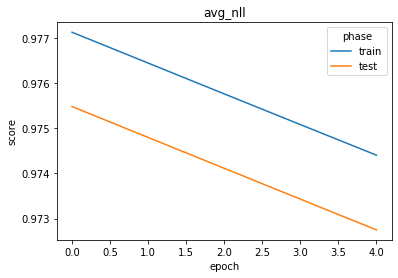

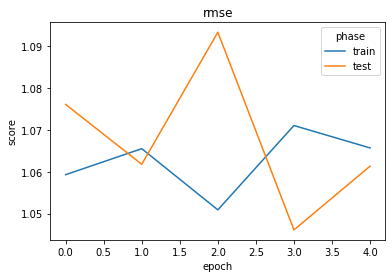

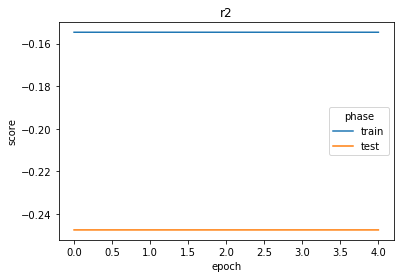

In [129]:
for metric in ['avg_nll', 'rmse', 'r2']:
    fig, ax = plt.subplots()
    sns.lineplot(
        data=results.query(f'metric == "{metric}"'),
        x='epoch',
        y='score',
        hue='phase',
        ax=ax
    )
    ax.set_title(metric)